# extract_insect_images.ipynb

This notebook:
* reads a a sticky trap image file (**IMAGEPATH**)
* detects all insects
* extracts each insect as an image and stores it in a folder (**OUTPUTPATH**) 
* insects images close to the edges of the image and close to the qrcode label at the center are excluded
* insect images with an aspect ratio exceeding MAX_ASPECT_RATIO are excluded.

2022-04-12 added code to delete insect images near edges

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
from shapely.geometry import Polygon

In [3]:
# This cell is tagged as "parameters" to enable use of papermill

IMAGEPATH = '/home/aubrey/Desktop/test/22/cropped.png'
OUTPUTPATH = '/home/aubrey/Desktop/test/22'
CANNY = 45
MAX_ASPECT_RATIO = 4.0

In [4]:
def rotate_and_crop(imagepath, outputpath, rects):
    '''
    imagepath: path to image file
    
    rects: a list of rectangular areas returned by bugcount; cv2.minAreaRect formats each rectangle as:
          (center(x, y), (width, height), angle of rotation)
        
    outputpath: specifies a directory in which rotated and cropped images are saved; each is named NNN.png
    
    Code inspired by https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/
    '''
    
#     if not os.path.exists(outputpath):
#         os.makedirs(outputpath)
 
    img = cv2.imread(IMAGEPATH)
    
    for i, rect in enumerate(rects):
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # get width and height of the detected rectangle
        width = int(rect[1][0])
        height = int(rect[1][1])
        src_pts = box.astype("float32")

        # coordinate of the points in box points after the rectangle has been straightened
        dst_pts = np.array([[0, height-1],
                            [0, 0],
                            [width-1, 0],
                            [width-1, height-1]], dtype="float32")

        # the perspective transformation matrix
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # directly warp the rotated rectangle to get the straightened rectangle
        warped = cv2.warpPerspective(img, M, (width, height))
        
        sn = OUTPUTPATH.split('/')[-1] 
#         print(f'{sn=}')
        fname = f'{OUTPUTPATH}/{sn}-{i:03d}.png'
#         print(fname)
        cv2.imwrite(fname, warped)
        
#         # Rotate so that the long axis is vertical
#         height, width, _ = warped.shape
#         if height < width:
#             warped = cv2.rotate(warped, cv2.cv2.ROTATE_90_CLOCKWISE)             
#         cv2.imwrite(f'{outputpath}/{i:03d}a.png', warped)
#         warped = cv2.rotate(warped, cv2.cv2.ROTATE_180)             
#         cv2.imwrite(f'{outputpath}/{i:03d}b.png', warped)
        
# rotate_and_crop(IMAGEPATH, OUTPUTPATH, rects)

In [5]:
def bugcount(imagepath, canny=75):
    '''
    This code is based on bugcount.py from https://github.com/ytakefuji/counting-for-entomologists.
    '''
    img = cv2.imread(imagepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    blurred = cv2.GaussianBlur(blurred, (7,7), 0)
    coeff=int((blurred.max()-blurred.min())/100)
    if coeff==1: 
        coeff=1 
    else: 
        coeff=3
    outline = cv2.Canny(blurred, 0, int(canny)*coeff)
    outline= cv2.GaussianBlur(outline, (3,3), 0)
    
    # remove contours near edges or center of image or those exceeding MAX_ASPECT_RATIO
    contours, _ = cv2.findContours(outline,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
    contours = find_contours_not_touching_edge(contours, xmin=1, xmax=img.shape[1]-1, ymin=1, ymax=img.shape[0]-1)
    contours = find_contours_not_near_center(contours)
    contours = find_contours_not_exceeding_max_aspect_ratio(contours)
       
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)    
    cv2.putText(img,f'{imagepath} canny: {canny} contour count: {len(contours)}',(30,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
    
    # Calculate bounding boxes

    boxes = []
    rects = []
    for i, contour in enumerate(contours):
        rect = cv2.minAreaRect(contour)
        rects.append(rect)
        box = np.int0(cv2.boxPoints(rect))
        boxes.append(box)
        cv2.drawContours(img, [box], 0, (0, 0, 255), 3) 
        xcenter = int((box[0][0]+box[1][0]+box[2][0]+box[3][0])/4)
        ycenter = int((box[0][1]+box[1][1]+box[2][1]+box[3][1])/4)
        cv2.putText(img, str(i), (xcenter, ycenter), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    return contours, rects, boxes, img

In [6]:
def find_contours_not_touching_edge(contours, xmin, xmax, ymin, ymax):
#     img = cv2.imread(IMAGEPATH)
#     ymax, xmax, _ = img.shape

    contours_not_touching_edge = []
    for contour in contours: 
        x, y, w, h = cv2.boundingRect(contour)
        if (x > xmin) and (x+w < xmax-1) and (y > ymin) and (y+h < ymax-1):
            contours_not_touching_edge.append(contour)

    print(f'Count of all contours: {len(contours)}')
    print(f'Count of contours not touching edge: {len(contours_not_touching_edge)}')
    return contours_not_touching_edge

In [7]:
def find_contours_not_near_center(contours):
    pcenter = Polygon([(1100, 1100), (1500, 1100), (1500, 1500), (1100, 1500)])    
    
    contours_not_near_center = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        p = Polygon([(x, y), (x+w, y), (x+w, y+h), (x, y+h)])
        contour_near_center = p.intersects(pcenter)
        if not contour_near_center:
            contours_not_near_center.append(contour)

    print(f'Count of all contours: {len(contours)}')
    print(f'Count of contours not near center: {len(contours_not_near_center)}')
    return contours_not_near_center        

In [ ]:
def find_contours_not_exceeding_max_aspect_ratio(contours):
    valid_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = max(h/w, w/h)
        if aspect_ratio <= MAX_ASPECT_RATIO:
            valid_contours.append(contour)
    print(f'Count of all contours: {len(contours)}')
    print(f'Count of contours not exceeding MAX_ASPECT_RATIO ({MAX_ASPECT_RATIO}): {len(valid_contours)}')
    return valid_contours

Count of all contours: 46
Count of contours not touching edge: 44
Count of all contours: 44
Count of contours not near center: 43


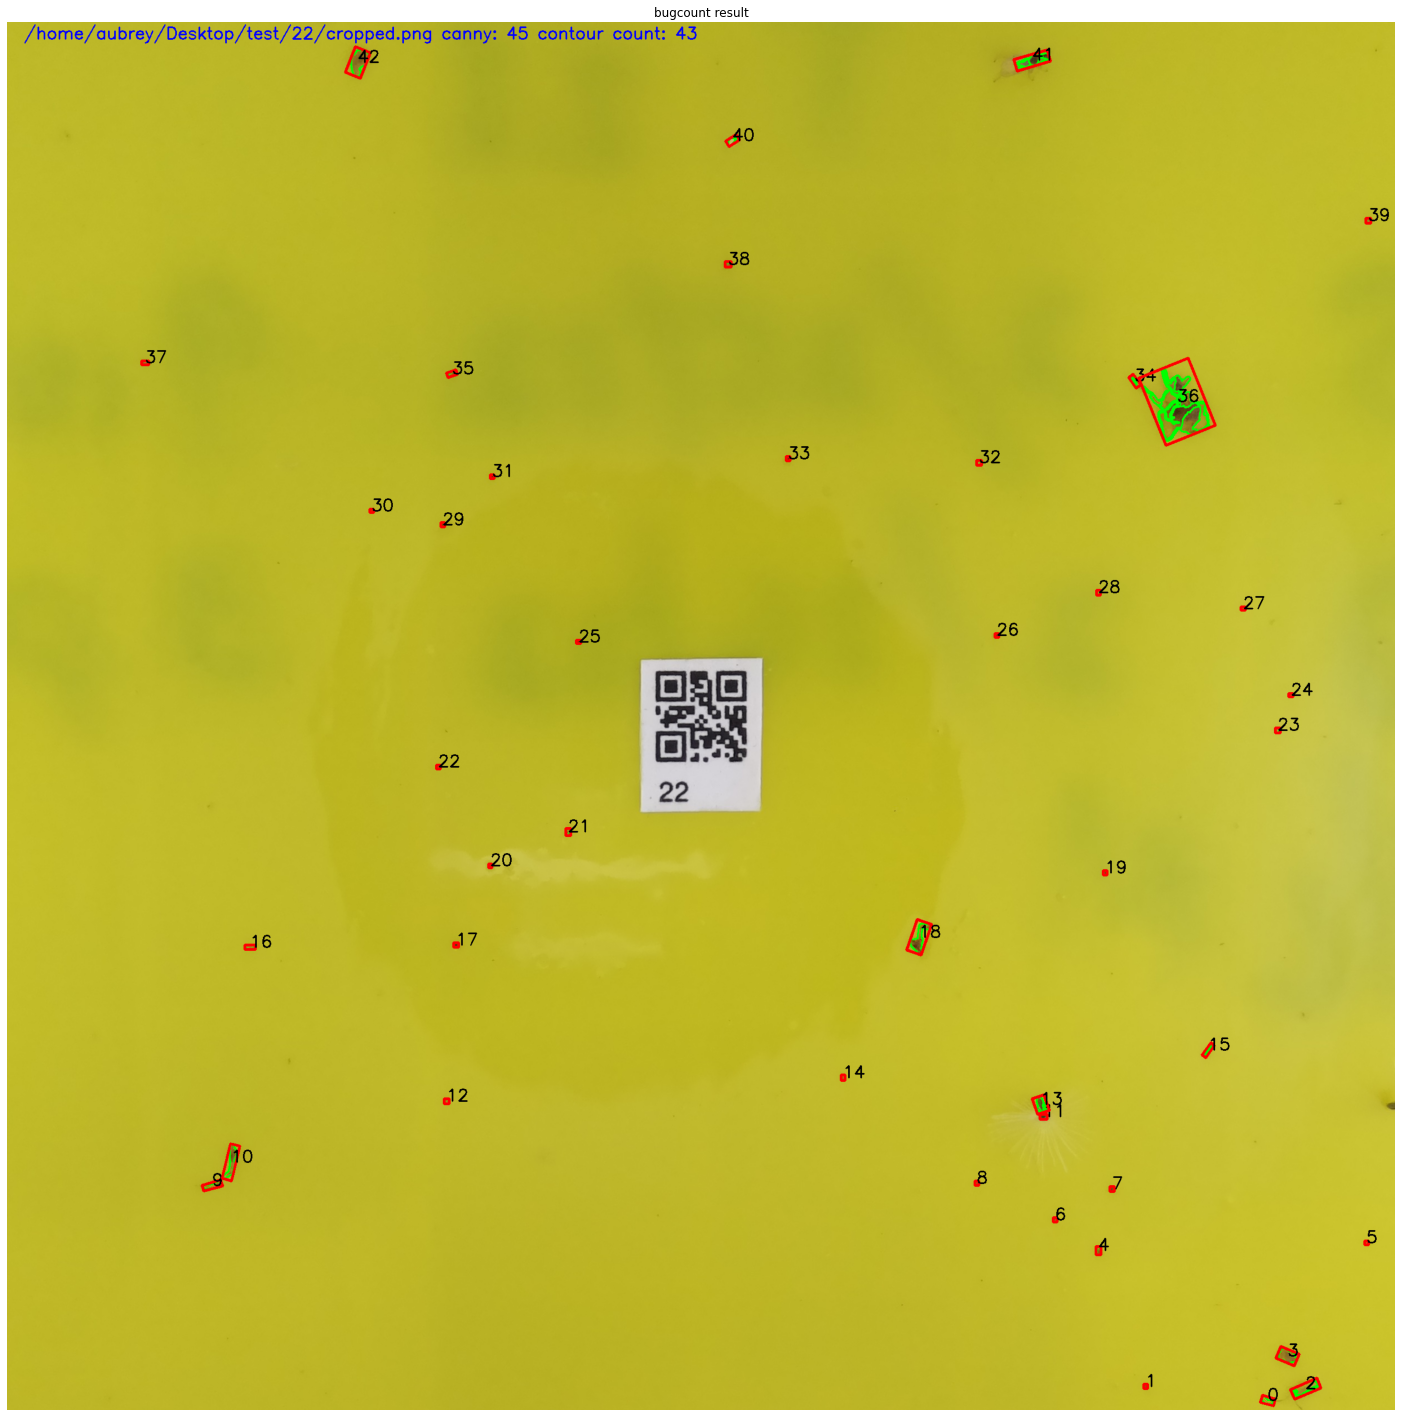

In [8]:
# MAIN

# Use the bugcount algorithm to draw contours around insects and other objects

contours, rects, boxes, img = bugcount(IMAGEPATH, CANNY)

# Display bugcount result image

fig, ax = plt.subplots(1, 1, figsize=(20,20))
fig.tight_layout()
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('bugcount result')
ax.axis('off')

# Save bugcount result map
cv2.imwrite(f'{OUTPUTPATH}/map.png', img) 

# Extract pixels within each rotated rectangle and rotate so that one axis is horizontal and the other is vertical
# Resulting images will be saved in OUTPUTPATH directory

rotate_and_crop(IMAGEPATH, OUTPUTPATH, rects)